In [1]:
import scipy.io
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd


In [2]:
# Problem 1 - K-Means

# generate 2d classification dataset (toy dataset with 2-dimensions)

from sklearn.datasets import make_blobs


X, y = make_blobs(n_samples=100, centers=3, n_features=2)


In [3]:
# Write K-means algorithm

class K_means:
    def __init__(self, K, iterations):
        self.iterations = iterations
        self.K = K
    
    # fit argument for Kmeans
    def fit(self, data, K, iterations):
        # get means and initialize means
        
        self.means = []
        
        for i in range(self.K):
            self.means.append(data[i])
        for i in range(self.iterations):
            # get data points to be part of groups
            groups = []
            
            for j in range(self.K):
                groups.append([])
            for p in data:
                dist = [((p - mean_val) **2).sum() for mean_val in self.means] # distance to mean values
                minimum = min(dist)
                dist_index = dist.index(minimum) # mean to get to min distance
                groups[dist_index].append(p) # get the point p to the group
                
            # calculate new mean
            flag = False
            for j in range(self.K):
                n_mean = np.average(groups[j], axis = 0)
                if not np.array_equal(self.means[j], n_mean):
                    flag = True
                self.means[j] = n_mean
            if not flag:
                break
                
    #predict argument for Kmeans
    def predict(self, test):
        preds = []
        # distances to mean values
        for p in test:
            dist = [((p - mean_val) **2).sum() for mean_val in self.means] # distance to mean values
            minimum = min(dist) # minimum distance
            dist_index = dist.index(minimum) # mean to get to min distance
            preds.append(dist_index) # get the point p to the group
        return preds
            
            


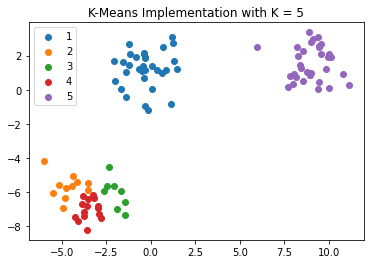

In [4]:
# Test algorithm

k_means = K_means(K = 5, iterations = 100)

k_means.fit(X, K = 5, iterations = 100)
label = k_means.predict(X)


# plot results

u_labels = np.unique(label)

for i in u_labels:
    plt.scatter(X[label == i, 0], X[label == i, 1], label = i+1)
    
plt.title("K-Means Implementation with K = 5")
        
plt.legend()
plt.show()

In [5]:
# Problem 2 - Gap Statistic

# Load in data

data = scipy.io.loadmat('HW5.mat')

X = data['X']



In [9]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


# implement Gap Statistic with sckit-learn KMeans

max_k = 20 + 1 # to account for 0 index

def optimalK(data, B = 100, maxK = max_k): # B = 100 and max_k goes up to 20
    
    # Get the evaluation of K from 1 to 20 (max)
    gaps = np.zeros((len(range(1, maxK)),))
    std_errors = np.zeros((len(range(1, maxK)),))
    results = pd.DataFrame({'K':[], 'Gap Statistic':[]})
    for i, k in enumerate(range(1, maxK)):

        # reference initialization
        ref_array = np.zeros(B)

        # For B references, generate datasets from PCA and perform kmeans
        for j in range(B):
            
            # Create new reference (null) datasets with principal component
            pca = PCA(2)
            pca.fit(X)
            reference_PCA = pca.transform(X)
            
            # Fit to it
            km = KMeans(k)
            km.fit(reference_PCA)
            
            ref_score = km.inertia_ # reference scores
            ref_array[j] = ref_score

        # Fit cluster to original data to calculate gap
        km = KMeans(k)
        km.fit(data)
        
        orig_score = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(ref_array)) - np.log(orig_score)
        
        # Get std_error for error bars
        error = np.log(ref_array - np.log(orig_score))
        std_error = np.std(error)
        

        # Put gap statistic into overall array of gap statistics
        gaps[i] = gap
        std_errors[i] = std_error
        results = results.append({'K':k, 'Gap Statistic':gap, 'Standard error': "{:.7f}".format(std_error)}, ignore_index=True)
        

    return (results)  




In [10]:
# Perform the long operation of Gap Statistic and save it to variable so do not have to reperform this...

gap_statistic = optimalK(X)




In [11]:
# Results in pandas dataframe

print(gap_statistic)

       K  Gap Statistic Standard error
0    1.0      -1.074621      0.0000000
1    2.0      -1.461978      0.0042615
2    3.0      -1.869208      0.0027083
3    4.0      -2.316360      0.0033094
4    5.0      -2.570559      0.0191556
5    6.0      -2.719729      0.0284757
6    7.0      -2.797538      0.0154553
7    8.0      -2.954304      0.0161611
8    9.0      -3.095453      0.0217759
9   10.0      -3.242088      0.0059496
10  11.0      -3.393246      0.0481986
11  12.0      -3.658543      0.0000005
12  13.0      -4.052786      0.0000003
13  14.0      -4.569820      0.0000003
14  15.0      -4.400049      0.0000006
15  16.0      -2.735086      0.0000000
16  17.0      -2.767192      0.0061682
17  18.0      -2.789953      0.0073006
18  19.0      -2.803965      0.0093774
19  20.0      -2.828864      0.0111137


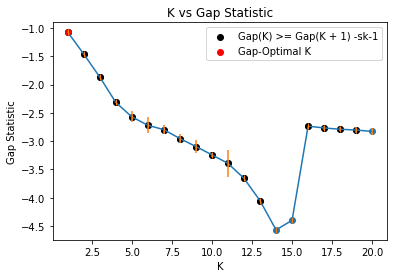

In [18]:
# Graph the results

y_plot = gap_statistic[["Gap Statistic"]]
x_plot = gap_statistic[["K"]]
y_err = gap_statistic[["Standard error"]]
y_err_flatten = y_err.values.flatten()

x_plot_err = []
for i in range(20):
    x_plot_err.append(float(x_plot.iat[i,0]))

y_plot_err = []
for i in range(20):
    y_plot_err.append(float(y_plot.iat[i, 0]))
    
y_errs = [float(i) for i in y_err_flatten]

y_errs_test = [i * 5 for i in y_errs] #maginfied

plt.scatter(x_plot, y_plot)
plt.plot(x_plot, y_plot)


# Adding error bars 

plt.errorbar(x_plot_err, y_plot_err, yerr = y_errs_test,fmt = '|')

# Values where Gap(K) >= Gap(K + 1) -sk-1

for i in range(13):
    labs = plt.scatter(x_plot['K'][i], y_plot['Gap Statistic'][i], color = 'black')
    
for i in range(15,19):
    labs = plt.scatter(x_plot['K'][i], y_plot['Gap Statistic'][i], color = 'black')

    

# Gap-Optimal K:  argmin {Gap(K) >= Gap(K+1) - sk+1} or more informally... when the rate of increase begins to "slow down"
# gap statistic immediately decreases for 𝑘>1. So the first 𝑘 that satisfies the 1-standard-error criterion is 1

# Hence Optimal K = 1
plt.scatter(x_plot['K'][0], y_plot['Gap Statistic'][0], color = 'red', label = 'Gap-Optimal K')




labs.set_label('Gap(K) >= Gap(K + 1) -sk-1')

plt.xlabel('K')
plt.ylabel('Gap Statistic')
plt.title('K vs Gap Statistic')

plt.legend()

plt.show()

